In [780]:
import pandas as pd
import cv2 as cv2
import matplotlib.pyplot as plt
import numpy as np
import math
import copy
import random

In [781]:
# from google.colab import drive
# drive.mount('/content/drive')

**>Definir el problema**

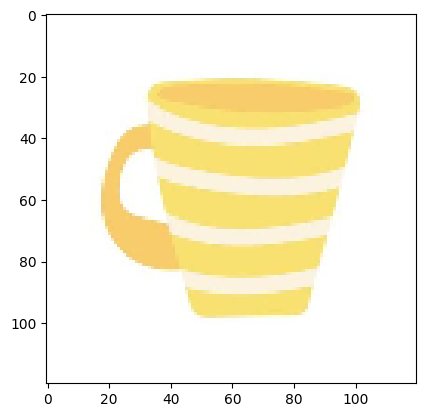

In [782]:
# img_or=cv2.imread('/content/drive/MyDrive/OptimizacionYMetaheursiticaII/Differential_evolution/taza.jpg')
img_or = cv2.imread('images/taza.jpeg')
# img_or = cv2.imread('images/blue.jpeg')
img_or = cv2.resize(img_or, (0,0), fx=0.3, fy=0.3)
# img_or = cv2.imread('images/m2.jpg')
img_or=cv2.cvtColor(img_or, cv2.COLOR_BGR2RGB) 
width,height,ch = img_or.shape

plt.figure()
plt.imshow(img_or)
plt.show()

In [783]:
#bounds: x=width, y=height, r=radio, R, G ,B alpha=transparencia
bounds =np.array([ [0,width],  #ancho
           [0,height],  # alto
           [3,(width)//2], #radio
           [0,255],  #R
           [0,255],  #G
           [0,255],  #B
           [0,255]    #Alpha --> Transparencia       
         ])


**>Impresion**

In [784]:
def objective_function(P, args) : # img_or, img_prueba): #img prueba la que va actualizando
  img_or, img_prueba = args
  #Parametros de la imagen
  width, height, radio, R, G, B, alpha = int(P[0]), int(P[1]), int(P[2]), int(P[3]), int(P[4]), int(P[5]), int(P[6])

  img_ind = copy.deepcopy(img_prueba)
  img_ind = cv2.circle(img_ind,(width,height), radio, (R, G, B), -1) #Ingresamos el circulo con los parametros dados
  img_ind = cv2.addWeighted(img_ind, alpha/255, img_prueba, 1 - alpha/255, 0) #Ingresamos el circulo con los parametros dados

  return np.sum( np.abs( img_ind - img_or) ) #% de pixeles diferentes

def draw_solution(P, img_prueba, return_sol = False):
  #Parametros de la imagen
  width, height, radio, R, G, B, alpha = int(P[0]), int(P[1]), int(P[2]), int(P[3]), int(P[4]), int(P[5]), int(P[6])
  
  img_ind = copy.deepcopy(img_prueba)
  img_ind = cv2.circle(img_ind,(width,height), radio, (R, G, B), -1) #Ingresamos el circulo con los parametros dados
  img_ind = cv2.addWeighted(img_ind, alpha/255, img_prueba, 1 - alpha/255, 0) #Ingresamos el circulo con los parametros dados
 
  #Mostramos las imagen con circulos
  plt.imshow(img_ind)
  plt.show()

  if return_sol:
    return img_ind

**>Initial population**

In [785]:
#Cada individuo=circulo con variables de bounds
def initial_population(n, bounds): 
  popx = np.zeros(( n, len(bounds)))
  for j in range(len(bounds)):
    popx[:,j] = np.random.uniform(bounds[j, 0], bounds[j, 1],size=(n)) #agarramos los nuevos valores 
  return popx

**>Mutation**

In [786]:
def mutation(population,popsize): 
  i1 = random.randint(0, popsize-1)
  i2 = random.randint(0, popsize-1)
  i3 = random.randint(0, popsize-1)
  x1 = population[i1, :]
  x2 = population[i2, :]
  x3 = population[i3, :]
  f = np.random.uniform(0, 2, x3.shape)
  v = x1 + f*(x2 - x3) # Ecuación de mutación 
  v = np.clip(v, bounds[:, 0], bounds[:, 1])
  return v

**>Crossover**

In [787]:
def crossover(xi, v, cr):
  u = np.zeros_like(v)
  l = np.random.randint(len(v))
  for k in range(len(u)):
    if (np.random.rand() <= cr or k == l):
      u[k] = v[k]
    else:
      u[k] = xi[k]
  return u

**>Selection**

In [788]:
#population,fitness, i,u,func,args
def selection(population,fitness, i, u, func, args):
  fitnessu = func(u,args)
  if( fitnessu < fitness[i] ):
    population[i] = u
    fitness[i] = fitnessu
  return population,fitness  

**Differential Evolution**

In [789]:
#Parametros
def differential_evolution(func,bounds,args,n=100,cr=0.9,g=1000):
  img_or, img_prueba = args
  population = initial_population(n, bounds)
  fitness_population = np.zeros(n)
  for i in range(n):
    fitness_population[i] = func(population[i, :], args)
  i = 0
  while(i < g):
    i = i+1
    for j in range(n):
      v = mutation(population, n)
      v = crossover(population[j], v, cr)
      population, fitness_population = selection(population, fitness_population, j, v, func, args)
  
  idx = np.argmin(fitness_population)
  individual = population[idx]
  return individual

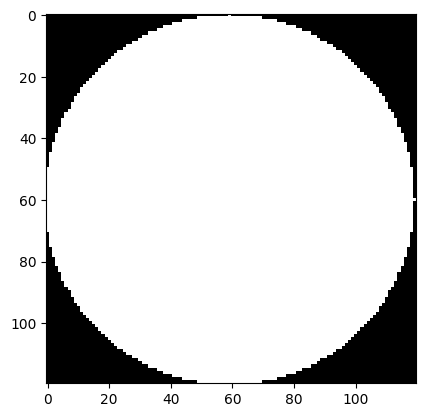

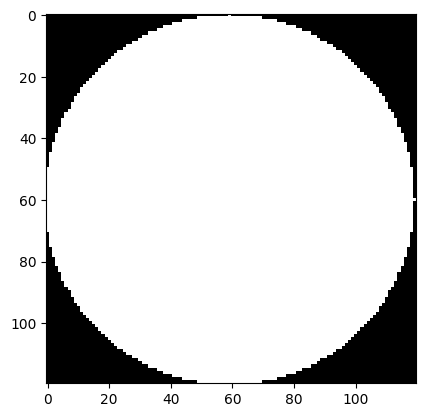

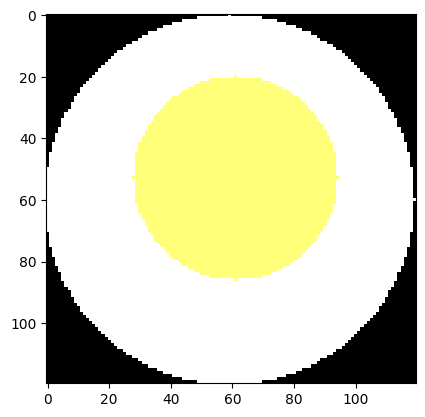

In [790]:
#Extrayendo los datos de nuestra imagen original
img = np.zeros_like(img_or)
for circulo in range(3):
    sol = differential_evolution(objective_function,bounds, (img_or.copy(), img.copy()), n=50, cr=0.8, g=250)
    error = objective_function(sol, (img_or, img))
    img = draw_solution(sol, img, return_sol = True)